In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


In [0]:
import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [3]:
import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input,LSTM,Embedding,Dense,Concatenate,TimeDistributed,Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings 
pd.set_option("display.max_colwidth",200)
warnings.filterwarnings("ignore")



Using TensorFlow backend.


In [0]:
cleaned_summary=pd.read_csv('/content/drive/My Drive/dataset/iit delhi/cleansummary_startend_data.csv')
cleaned_text=pd.read_csv('/content/drive/My Drive/dataset/iit delhi/cleantext_startend_data.csv')

In [38]:
print(len(cleaned_summary))
print(len(cleaned_text))

78297
78297


In [39]:
cleaned_text

,Unnamed: 0,comment
0,0,august today precious day someone special born fight sin save trust god something unexplainably lovely small hill towns one ventured surely relate dreaming waking beautiful mesmerizing view mounta...
1,1,study suggests migration rural areas rural areas plain districts state uttarakhand largely problem perception little geographical realities devi great gift idea chicago cubs game baseball jewlery ...
2,2,activate option huge disappointment plate year chances pastseasons little production sad albert point tough decisions made temple kosi katarmal district almora bloop rbi single ends third throwing...
3,3,agree season long slump ever get another hit disappointing plate fouls end inning leave couple plateand tied mid infield knock hill locally known jhandi dhar offers panoramic view kumaon hills gre...
4,4,dunagiri temple temple vlog shining souls required medical practitioner like free medical health camp project working support incomes non farm livelihoods strengthen food production system said di...
...,...,...
78292,78317,situated city place filled claasic architectural splendor gopi chillin quick guide safe ready best mridanga waiting brahmotsavam begins shri goda hardev mandir vrindavan month finally great time v...
78293,78318,always strong support visitas muy cerca inspired high las ciudades banke bihariji mandir vrindavan divine presence let live day blissful note radhe krishna krishna love jiva clinic opened vrindava...
78294,78319,visit experience true essence colors devotion shri radharaman charan das babaji festival dogs mothers featured heritage dies vrindavan ghats went place religious feel planningembark even march mis...
78295,78320,worship radha lightining shyam cloud blessed attending temple arati amidst brightest colours closer gods celebrate traditional way plan trip litres petrol stolen mathura refinery pipeline live wor...


In [40]:
type(cleaned_summary)

pandas.core.frame.DataFrame

In [0]:
cleaned_summary=cleaned_summary['summary']
cleaned_text=cleaned_text['comment']

In [42]:
print(type(cleaned_summary),type(cleaned_text))

<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>


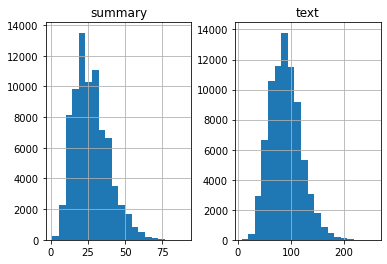

In [43]:
#counting number of words to get padding
import matplotlib.pyplot as plt
text_word_count=[]
for i in cleaned_text:
    text_word_count.append(len(i.split()))
    
summary_word_count=[]
for i in cleaned_summary:
    summary_word_count.append(len(i.split()))
    
length_df=pd.DataFrame({'text':text_word_count,'summary':summary_word_count})
length_df.hist(bins=20)
plt.show()

In [0]:
#splitting data for train and validation
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(cleaned_text,cleaned_summary,test_size=.1,random_state=0,shuffle=True)

In [45]:
print(len(x_tr))
print(len(y_tr))
print(len(x_val))
print(len(y_val))

70467
70467
7830
7830


In [46]:
type(x_tr)

pandas.core.series.Series

In [0]:
x_tokenizer = Tokenizer()
y_tokenizer = Tokenizer()

saving/loading tokenizer

code for reference

In [0]:
# #code
# import pickle

# # saving
# with open('tokenizer.pickle', 'wb') as handle:
#     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# # loading
# with open('tokenizer.pickle', 'rb') as handle:
#     tokenizer = pickle.load(handle)

In [0]:
import pickle
with open('/content/drive/My Drive/dataset/iit delhi/x_tokenizer.pickle', 'rb') as handle:
    x_tokenizer = pickle.load(handle)

with open('/content/drive/My Drive/dataset/iit delhi/y_tokenizer.pickle', 'rb') as handle:
    y_tokenizer = pickle.load(handle)

In [0]:
y_voc_size  =   len(y_tokenizer.word_index) +1
x_voc_size  =   len(x_tokenizer.word_index) +1

In [0]:
max_len_text=100
max_len_summary=35
latent_dim=500

In [52]:
print(x_voc_size)
print(y_voc_size)
print(max_len_text)
print(max_len_summary)
print(latent_dim)

281181
140347
100
35
500


In [0]:
#convert text sequences into integer sequences
x_tr    =   x_tokenizer.texts_to_sequences(list(x_tr)) 
x_val   =   x_tokenizer.texts_to_sequences(list(x_val))

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr,  maxlen=max_len_text, padding='post') 
x_val   =   pad_sequences(x_val, maxlen=max_len_text, padding='post')

In [0]:

#convert summary sequences into integer sequences
y_tr    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr, maxlen=max_len_summary, padding='post')
y_val   =   pad_sequences(y_val, maxlen=max_len_summary, padding='post')

In [55]:
print(len(x_tr))
print(len(y_tr))
print(len(x_val))
print(len(y_val))

70467
70467
7830
7830


In [56]:
x_tr[0]

array([   472,    232,   4353,  22866,    137,  16397,   3563, 122467,
          100,   2700,     60,   4754,      2,   1750,   9581,  17884,
         7561,   1123,  11280,    296,   2563,    621,  13746,    268,
         2700,     48,  28849,   5387,   2893,  19766,     33,   5387,
         2700,    997,  84070,     39,    165,   7301,   2869,   1533,
        16398,   1440,   2135,     91,    284,     16,     18,    365,
           14,   2218,   5500,   1643,    789,  12309,    481,   4249,
         1291,   7459,    942,    209,    100,     97,   1586,  13160,
          358,     39,   6527,    170,    234,    385,   2000,   6310,
         2653,   1055,   2188,    102,     18,    473,   1383,    789,
          122,   1364,   1258,   2246,    142,    551,  11281,  18745,
        11993,  11994,   1438,    209,      0,      0,      0,      0,
            0,      0,      0,      0], dtype=int32)

In [57]:
y_tokenizer.texts_to_sequences(["physics is nice","this is bad"]) 

[[11440, 672], [743]]

In [0]:
from tensorflow.keras import backend as K
K.clear_session()

model designing


In [59]:
#first we will define all the layers of the model than add them 

######encoder
encoder_inputs=Input(shape=(max_len_text,))

#embedding
enc_emb=Embedding(x_voc_size,latent_dim,trainable=True)(encoder_inputs)

#lstm 1
encoder_lstm1=LSTM(latent_dim,return_sequences=True,return_state=True)
encoder_output1,state_h1,state_c1=encoder_lstm1(enc_emb)

#lstm2
encoder_lstm2=LSTM(latent_dim,return_sequences=True,return_state=True)
encoder_outputs,state_h,state_c=encoder_lstm2(encoder_output1)

#####decoder
decoder_inputs=Input(shape=(None,))

#embedding
dec_emb_layer=Embedding(y_voc_size,latent_dim,trainable=True)
dec_emb=dec_emb_layer(decoder_inputs)

#lstm1
decoder_lstm=LSTM(latent_dim,return_sequences=True,return_state=True)
decoder_outputs,decoder_fwd_state,decoder_back_state=decoder_lstm(dec_emb,initial_state=[state_h,state_c])

#Attention layer
attn_layer=AttentionLayer(name='attention_layer')
attn_out,attn_state=attn_layer([encoder_outputs,decoder_outputs])

#concatenate attention output with decoder output
decoder_concat_input=Concatenate(axis=-1,name='concat_layer')([decoder_outputs,attn_out])

#dense layer
#importnat to study timedistributed layer and its feature

decoder_dense=TimeDistributed(Dense(y_voc_size,activation='softmax'))
decoder_outputs=decoder_dense(decoder_concat_input)

#now summing up the model
model=Model([encoder_inputs,decoder_inputs],decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 500)     140590500   input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 100, 500), ( 2002000     embedding[0][0]                  
______________________________________________________________________________________________

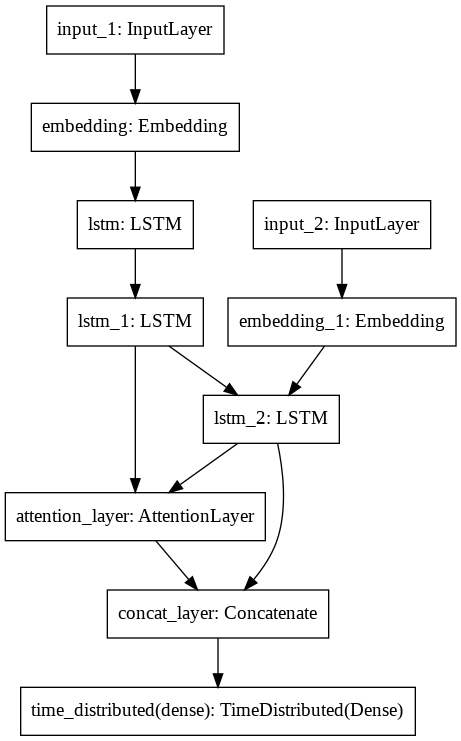

In [60]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='/content/drive/My Drive/dataset/iit delhi/model1.png')

In [0]:
model.compile(optimizer='rmsprop',loss='sparse_categorical_crossentropy')

In [0]:
es=EarlyStopping(monitor='val_loss',mode='min',verbose=1)

# es = EarlyStopping(monitor='val_acc', min_delta=.001, patience=5,mode="max")

In [63]:

#lets train 
# %%time
# BATCH_SIZE=512
# EPOCHS=10
from keras.callbacks import ModelCheckpoint

#  model_checkpoint=ModelCheckpoint('/kaggle/working/bestmodel1.hdf5', monitor='val_loss',verbose=1, savebest_only=True,save_weights_only=False,mode='auto',period=1)
modelcheckpoint = ModelCheckpoint("/content/drive/My Drive/dataset/iit delhi/tourist_summ.h5", save_best_only=True, verbose=1)
# model_checkpoint = ModelCheckpoint(filepath='movie_review_epoch-{epoch:02d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.h5',
#                                   monitor='val_loss',
#                                   verbose=1,
#                                   save_best_only=True,
#                                   save_weights_only=False,
#                                   mode='auto',
#                                   period=1)

# model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
#           batch_size=batch_size,
#           epochs=epochs,
#           validation_split=0.2)\]  '
# model.fit([x_tr,y_tr],y_tr,epochs=30,callbacks=[es],batch_size=512, validation_data=([x_val,y_val],y_val))
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=15,callbacks=[es],batch_size=32, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))


Epoch 1/15
2203/2203 [==============================] - 2312s 1s/step - loss: 6.4597 - val_loss: 5.8123
Epoch 2/15
2203/2203 [==============================] - 2321s 1s/step - loss: 5.1854 - val_loss: 3.9737
Epoch 3/15
2203/2203 [==============================] - 2330s 1s/step - loss: 3.6500 - val_loss: 3.1780
Epoch 4/15
2203/2203 [==============================] - 2327s 1s/step - loss: 3.1149 - val_loss: 2.8815
Epoch 5/15
2203/2203 [==============================] - 2310s 1s/step - loss: 2.8674 - val_loss: 2.6473
Epoch 6/15
2203/2203 [==============================] - 2324s 1s/step - loss: 2.6873 - val_loss: 2.5639
Epoch 7/15
2203/2203 [==============================] - 2331s 1s/step - loss: 2.5119 - val_loss: 2.4739
Epoch 8/15
2203/2203 [==============================] - 2332s 1s/step - loss: 2.3134 - val_loss: 2.4112
Epoch 9/15
2203/2203 [==============================] - 2332s 1s/step - loss: 2.1407 - val_loss: 2.3027
Epoch 10/15
2203/2203 [==============================] - 2343s 1

In [0]:
model.save('/content/drive/My Drive/dataset/iit delhi/touristsumm1.h5')

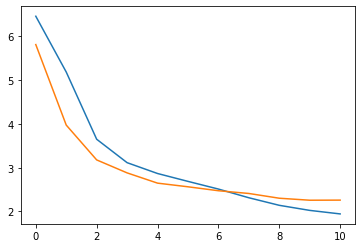

In [65]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
# pyplot.legend() pyplot.show()

In [0]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [0]:
#inference main part of language modelling

#encoder
encoder_model=Model(inputs=encoder_inputs,outputs=[encoder_outputs,state_h,state_c])

#decoder
decoder_state_input_h=Input(shape=(latent_dim,))
decoder_state_input_c=Input(shape=(latent_dim,))
decoder_hidden_state_input=Input(shape=(max_len_text,latent_dim))#this is the ouptut of encoder for each text

#get the embedding of decoder

dec_emb2=dec_emb_layer(decoder_inputs)

#to predict the next word 
decoder_outputs2,state_h2,state_c2=decoder_lstm(dec_emb2,initial_state=[decoder_state_input_h,decoder_state_input_c])

#attention layer inference
attn_out_inf,attn_states_inf=attn_layer([decoder_hidden_state_input,decoder_outputs2])
decoder_inf_concat=Concatenate(axis=-1,name='concat')([decoder_outputs2,attn_out_inf])

#dense softmax layer to generate prob distri.
decoder_outputs2=decoder_dense(decoder_inf_concat)

#final decoder model
decoder_model=Model([decoder_inputs]+[decoder_hidden_state_input,decoder_state_input_h,decoder_state_input_c],[decoder_outputs2]+[state_h2,state_c2])


In [0]:
#defing function for inference
# updating the  input of decoder and h and c 

def decode_sequence(input_seq):
    #encode the input as state vector
    e_out,e_h,e_c=encoder_model.predict(input_seq)
    target_seq=np.zeros((1,1))
    target_seq[0,0]=target_word_index['start']
    
    stop_condition=False
    decoded_sentence=''
    
    while not stop_condition:
        output_tokens,h,c=decoder_model.predict([target_seq]+[e_out,e_h,e_c])
        
        #sample a token
        sampled_token_index=np.argmax(output_tokens[0,-1,:])
        sampled_token=reverse_target_word_index[sampled_token_index]
#         print(sampled_token_index)
        if (sampled_token!='end'):
            decoded_sentence+=' '+sampled_token
            
            #checking exit condition
        if(sampled_token=='end' or len(decoded_sentence.split())>=(max_len_summary-1) ):
            stop_condition=True
            
        #update input word of decoder to previous predict word    
        target_seq=np.zeros((1,1))
        target_seq[0,0]=sampled_token_index
        #update h and c
        e_h,e_c=h,c
    return decoded_sentence

In [0]:
#now lets make a function to convert all the input text ,summary from int to text

def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if (i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString


70467

In [81]:

for i in range(10):
  print(i)
  print("Review:",seq2text(x_val[i]))
  print("Original summary:",seq2summary(y_val[i]))
  print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_len_text)))
  print("\n")

0
Review: push implement public transport without delay places like done tenure people highly solicited received official mascot along excitement air gathering huge full enthusiasm many seven persons left burn injuries diwali revelry admitted district headquarters hospital persons including minor boy injured separate incidents celebration rasalpur chopra village bhanjanagar aska udala district two youths injured separate incidents rasalpur chopra village bhanjanagar flagged mission program raibania jaleswar panchayat program aims empowerment villages round development sea supporters sensitized people salient features mission attended laying ceremony road settlement chhak uday nagar shakti nagar mla help local people lot prayed almighty smooth completion project adressed gathering 
Original summary: people inquire well received official mascot along excitement air gathering huge full enthusiasm attended laying ceremony road settlement chhak uday nagar shakti nagar mla help local people 